## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [141]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [142]:
# set random seed
seed(10)

tf.random.set_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [143]:
df = pd.read_csv('turbine6.csv')

In [144]:
df=df.drop(columns=['Unnamed: 0', 'Turbine_ID',])

In [145]:
# transform data file index to datetime and sort in chronological order

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (50575, 9)


Timestamp  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  \
0  2016-01-01T00:00:00+00:00       1270.0       1232.8       1248.5   
1  2016-01-01T00:10:00+00:00       1429.7        203.9       1154.1   
2  2016-01-01T00:20:00+00:00       1360.5        250.3       1041.4   
3  2016-01-01T00:30:00+00:00       1399.2       1228.8       1252.5   
4  2016-01-01T00:40:00+00:00       1302.7       1225.1       1257.6   

   Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  \
0          6.8                 42                   51                   52   
1        271.7                 42                   51                   52   
2        382.7                 42                   50                   51   
3         16.5                 42                   49                   50   
4         13.4                 41                   50                   50   

   Gen_Phase3_Temp_Avg  
0                   53  
1                   52  
2                   51  
3                   50  
4                   51

In [146]:
df.index

RangeIndex(start=0, stop=50575, step=1)

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [147]:
train, test = df.loc[df['Timestamp'] <= '2016-09-01 00:00:00+0000'], df.loc[df['Timestamp'] > '2016-09-01 00:00:00+0000']
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (33354, 9)
Test dataset shape: (17221, 9)


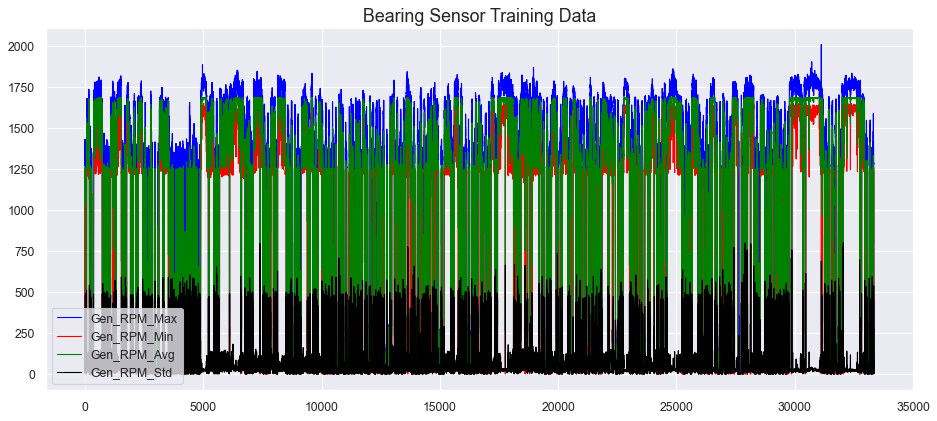

In [186]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Gen_RPM_Max'], label='Gen_RPM_Max', color='blue', animated = True, linewidth=1)
ax.plot(train['Gen_RPM_Min'], label='Gen_RPM_Min', color='red', animated = True, linewidth=1)
ax.plot(train['Gen_RPM_Avg'], label='Gen_RPM_Avg', color='green', animated = True, linewidth=1)
ax.plot(train['Gen_RPM_Std'], label='Gen_RPM_Std', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

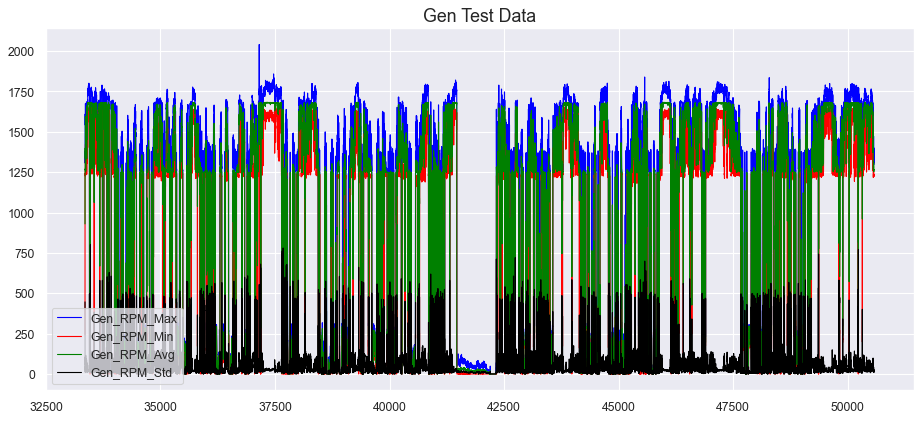

In [149]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Gen_RPM_Max'], label='Gen_RPM_Max', color='blue', animated = True, linewidth=1)
ax.plot(test['Gen_RPM_Min'], label='Gen_RPM_Min', color='red', animated = True, linewidth=1)
ax.plot(test['Gen_RPM_Avg'], label='Gen_RPM_Avg', color='green', animated = True, linewidth=1)
ax.plot(test['Gen_RPM_Std'], label='Gen_RPM_Std', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Gen Test Data', fontsize=16)
plt.show()

In [196]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=test['Timestamp'], y=df['Gen_RPM_Max'], name='Gen_RPM_Max' ))
fig.add_trace(go.Scatter(x=test['Timestamp'], y=df['Gen_RPM_Std'], name='Gen_RPM_Std' ))
fig.add_trace(go.Scatter(x=test['Timestamp'], y=df['Gen_RPM_Min'], name='Gen_RPM_Min' ))
fig.add_trace(go.Scatter(x=test['Timestamp'], y=df['Gen_Bear_Temp_Avg'], name='Gen_Bear_Temp_Avg'))

fig.update_layout(showlegend=True, title='Gen_Bear_Temp_Avg 2016')
fig.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [150]:
#train=train.drop(columns=['Timestamp',])

#test=test.drop(columns=['Timestamp',])
#train.loc[:, ['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']]

In [151]:
#test.set_index('Timestamp')

In [152]:
# normalize the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']])
scaled_test = scaler.transform(test[['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']])
#scaler_filename = "scaler_data"
#joblib.dump(scaler, scaler_filename)

In [153]:
scaled_traindf = train.copy()
scaled_testdf = test.copy()

In [154]:
scaled_traindf['Gen_RPM_Max'] = scaled_train[:,0]
scaled_traindf['Gen_RPM_Min'] = scaled_train[:,1]
scaled_traindf['Gen_RPM_Avg'] = scaled_train[:,2]
scaled_traindf['Gen_RPM_Std'] = scaled_train[:,3]
scaled_traindf['Gen_Bear_Temp_Avg'] = scaled_train[:,4]
scaled_traindf['Gen_Phase1_Temp_Avg'] = scaled_train[:,5]
scaled_traindf['Gen_Phase2_Temp_Avg'] = scaled_train[:,6]

scaled_traindf['Gen_Phase3_Temp_Avg'] = scaled_train[:,7]



scaled_traindf.head(3)

Timestamp  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  \
0  2016-01-01T00:00:00+00:00     0.633038     0.744040     0.741610   
1  2016-01-01T00:10:00+00:00     0.712641     0.123061     0.685536   
2  2016-01-01T00:20:00+00:00     0.678148     0.151065     0.618592   

   Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  \
0     0.008511           0.128342             0.158470             0.163934   
1     0.340050           0.128342             0.158470             0.163934   
2     0.478974           0.128342             0.153005             0.158470   

   Gen_Phase3_Temp_Avg  
0             0.169399  
1             0.163934  
2             0.158470

In [165]:
scaled_testdf['Gen_RPM_Max'] = scaled_test[:,0]
scaled_testdf['Gen_RPM_Min'] = scaled_test[:,1]
scaled_testdf['Gen_RPM_Avg'] = scaled_test[:,2]
scaled_testdf['Gen_RPM_Std'] = scaled_test[:,3]
scaled_testdf['Gen_Bear_Temp_Avg'] = scaled_test[:,4]
scaled_testdf['Gen_Phase1_Temp_Avg'] = scaled_test[:,5]
scaled_testdf['Gen_Phase2_Temp_Avg'] = scaled_test[:,6]

scaled_testdf['Gen_Phase3_Temp_Avg'] = scaled_test[:,7]



scaled_testdf.head(3)

Timestamp  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  \
33354  2016-09-01T00:00:00+00:00     0.687917     0.146177     0.552302   
33355  2016-09-01T00:10:00+00:00     0.672565     0.749653     0.754084   
33356  2016-09-01T00:20:00+00:00     0.651181     0.748084     0.750163   

       Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
33354     0.558698           0.085561             0.081967   
33355     0.025031           0.090909             0.098361   
33356     0.014268           0.096257             0.114754   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  
33354             0.120219             0.081967  
33355             0.125683             0.098361  
33356             0.142077             0.114754

In [166]:
scaled_testdf.set_index('Timestamp')
scaled_traindf.set_index('Timestamp')

Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  Gen_RPM_Std  \
Timestamp                                                                       
2016-01-01T00:00:00+00:00     0.633038     0.744040     0.741610     0.008511   
2016-01-01T00:10:00+00:00     0.712641     0.123061     0.685536     0.340050   
2016-01-01T00:20:00+00:00     0.678148     0.151065     0.618592     0.478974   
2016-01-01T00:30:00+00:00     0.697438     0.741626     0.743986     0.020651   
2016-01-01T00:40:00+00:00     0.649337     0.739393     0.747015     0.016771   
...                                ...          ...          ...          ...   
2016-08-31T23:10:00+00:00     0.044163     0.033195     0.045382     0.011139   
2016-08-31T23:20:00+00:00     0.126857     0.023900     0.079240     0.108135   
2016-08-31T23:30:00+00:00     0.135281     0.120707     0.143451     0.021151   
2016-08-31T23:40:00+00:00     0.138870     0.113405     0.140422     0.027409   
2016-08-31T23:50:00+00:00     0.126209     0.130847     0.140541     0.011264   

                           Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
Timestamp                                                           
2016-01-01T00:00:00+00:00           0.128342             0.158470   
2016-01-01T00:10:00+00:00           0.128342             0.158470   
2016-01-01T00:20:00+00:00           0.128342             0.153005   
2016-01-01T00:30:00+00:00           0.128342             0.147541   
2016-01-01T00:40:00+00:00           0.122995             0.153005   
...                                      ...                  ...   
2016-08-31T23:10:00+00:00           0.085561             0.081967   
2016-08-31T23:20:00+00:00           0.085561             0.081967   
2016-08-31T23:30:00+00:00           0.085561             0.081967   
2016-08-31T23:40:00+00:00           0.085561             0.081967   
2016-08-31T23:50:00+00:00           0.085561             0.081967   

                           Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  
Timestamp                                                            
2016-01-01T00:00:00+00:00             0.163934             0.169399  
2016-01-01T00:10:00+00:00             0.163934             0.163934  
2016-01-01T00:20:00+00:00             0.158470             0.158470  
2016-01-01T00:30:00+00:00             0.153005             0.153005  
2016-01-01T00:40:00+00:00             0.153005             0.158470  
...                                        ...                  ...  
2016-08-31T23:10:00+00:00             0.136612             0.081967  
2016-08-31T23:20:00+00:00             0.136612             0.081967  
2016-08-31T23:30:00+00:00             0.136612             0.081967  
2016-08-31T23:40:00+00:00             0.136612             0.076503  
2016-08-31T23:50:00+00:00             0.136612             0.076503  

[33354 rows x 8 columns]

In [167]:
# normalize the data

# scaler = MinMaxScaler()
#X_train = scaler.fit_transform(train[['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']])
#X_test = scaler.transform(test[['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']])
#scaler_filename = "scaler_data"
# joblib.dump(scaler, scaler_filename)

In [168]:
X_train = scaled_traindf.to_numpy()
X_test = scaled_testdf.to_numpy()




In [174]:
X_train.shape

(33354, 1, 9)

In [170]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (33354, 1, 9)
Test data shape: (17221, 1, 9)


In [171]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [172]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 9)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 16)             1664      
                                                                 
 lstm_21 (LSTM)              (None, 4)                 336       
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_23 (LSTM)              (None, 1, 16)             1344      
                                                           

In [173]:
# fit the model to the data
nb_epochs = 50
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

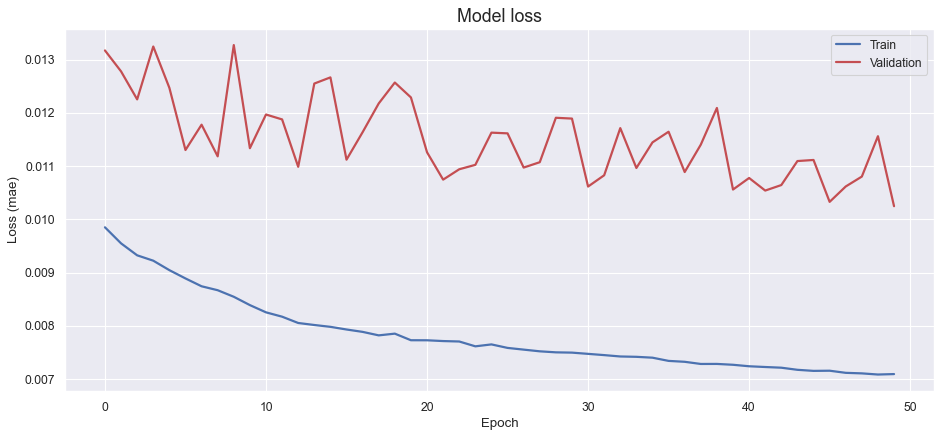

In [125]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [126]:
train.shape

(33354, 8)

/Users/nourelgarhy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

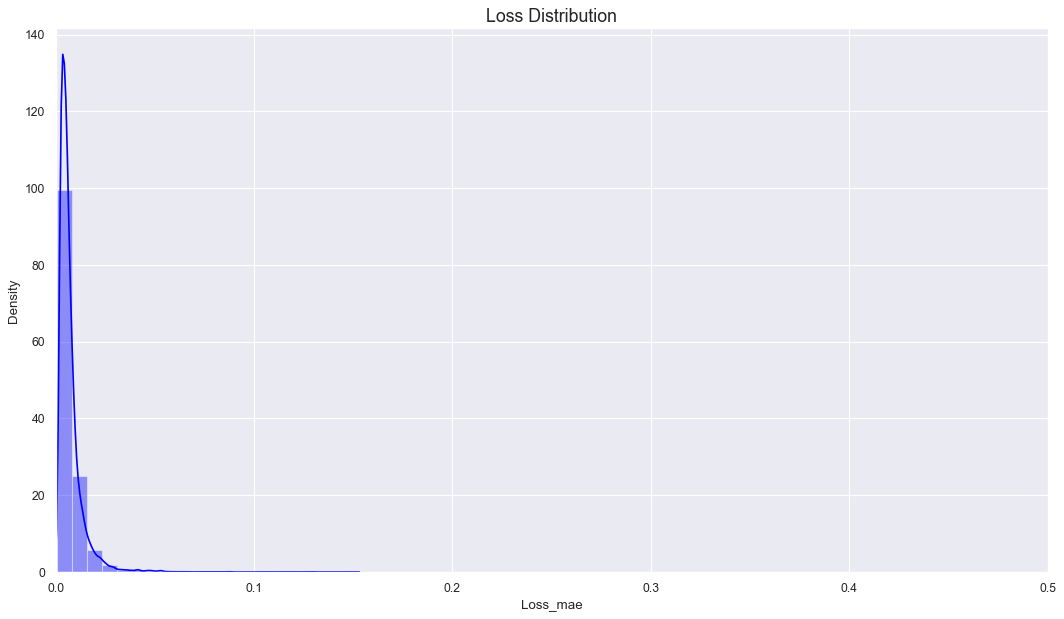

In [127]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.loc[:, ['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']].columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [202]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.loc[:, ['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']].columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.05
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.shape



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

33354    False
33355    False
33356    False
33357    False
33358    False
         ...  
50570    False
50571    False
50572    False
50573    False
50574    False
Name: Anomaly, Length: 17221, dtype: bool

In [138]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.loc[:, ['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std','Gen_Bear_Temp_Avg','Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']].columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.05
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
#scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

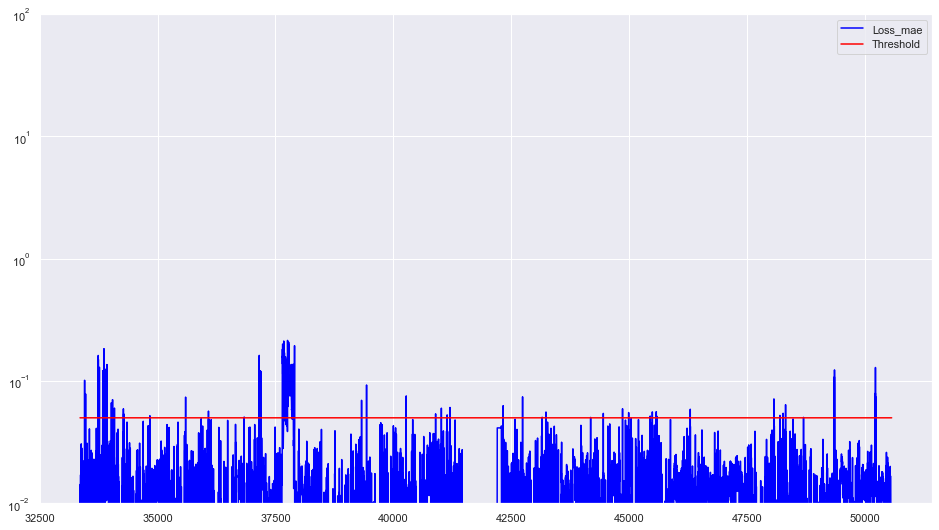

In [139]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [140]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
